# best nk=21

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
import validate
from sklearn.preprocessing import StandardScaler
import PR_curve
import extract_sound

In [43]:
data_dir='fixed_csv_label_ver2'
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


In [44]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

df_list=[]
for i in set(df['day']):
    lag=[] 
    window=5
    lag.append(make_data(df.loc[df['day']==i, ['original']], 'original', window))
    lag.append(df.loc[df['day']==i, ['day']])
    lag.append(make_label(df.loc[df['day']==i, ['label']], window))
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
df=pd.concat(df_list)
df=df.dropna().reset_index(drop=True)
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,day,label
0,53.6,53.2,52.8,52.8,53.4,0,0
1,54.0,53.6,53.2,52.8,52.8,0,0
2,54.7,54.0,53.6,53.2,52.8,0,0
3,55.7,54.7,54.0,53.6,53.2,0,0
4,55.5,55.7,54.7,54.0,53.6,0,0
...,...,...,...,...,...,...,...
3995305,45.9,45.6,45.4,45.9,46.0,9,0
3995306,45.6,45.9,45.6,45.4,45.9,9,0
3995307,45.8,45.6,45.9,45.6,45.4,9,0
3995308,45.7,45.8,45.6,45.9,45.6,9,0


# nk 1~3000

nk=1


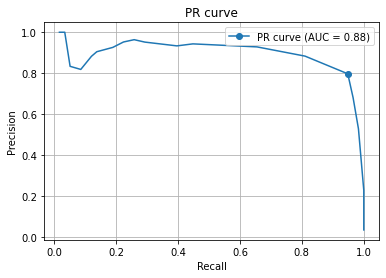

AUC：0.8777518898586159
閾値：0.21052631578947367
F値：0.8659861448464921
適合率：0.7968379446640316
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=10


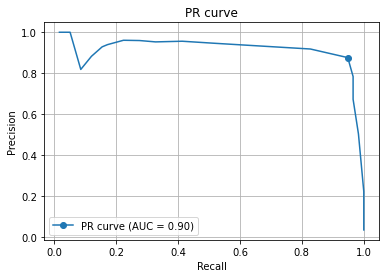

AUC：0.8996086391556708
閾値：0.2631578947368421
F値：0.9106988737466836
適合率：0.8759864712514093
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=100


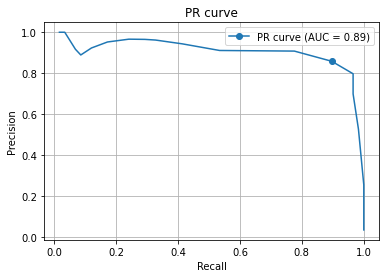

AUC：0.8893327580876671
閾値：0.2665838190960055
F値：0.8768860149613288
適合率：0.8580645161290322
再現率：0.896551724137931
-----------------------------------------------------------------------
nk=500


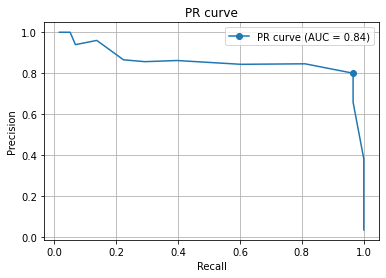

AUC：0.8402138788806646
閾値：0.16239813978173767
F値：0.8747840191826228
適合率：0.7996389891696751
再現率：0.9655172413793104
-----------------------------------------------------------------------
nk=1000


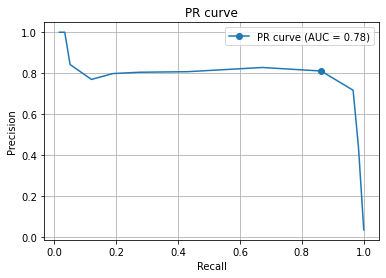

AUC：0.7824718471717146
閾値：0.16222155558242077
F値：0.8354393556480791
適合率：0.810405643738977
再現率：0.8620689655172413
-----------------------------------------------------------------------
nk=2000


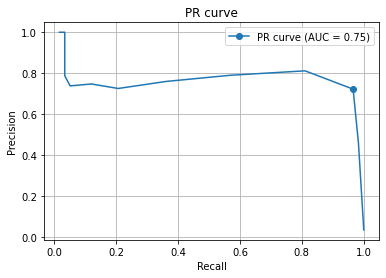

AUC：0.7470265615616378
閾値：0.10949529321911415
F値：0.8260403790688093
適合率：0.7217741935483871
再現率：0.9655172413793104
-----------------------------------------------------------------------
nk=3000


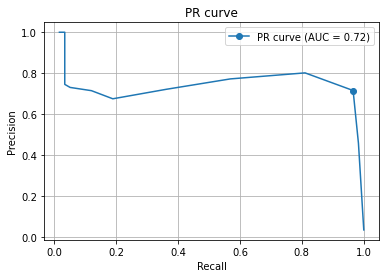

AUC：0.7242228220719638
閾値：0.10953373850531002
F値：0.8216628891804844
適合率：0.7151162790697675
再現率：0.9655172413793104
-----------------------------------------------------------------------


In [46]:
test_day=[3]
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
for i in [1, 10, 100, 500, 1000, 2000, 3000]:
    print(f'nk={i}')
    train=df[(~df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    
    nk = i
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx
    
    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
    
    d=test_v['d'].values
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = PR_curve.fig_pr(test_v, d, thr_bins)
    print(f'AUC：{auc}')
    print(f'閾値：{thr}')
    print(f'F値：{f_score.max()}')
    print(f'適合率：{p_score[np.argmax(f_score)]}')
    print(f'再現率：{r_score[np.argmax(f_score)]}')
    print('-----------------------------------------------------------------------')

# nk 2~9

nk=2


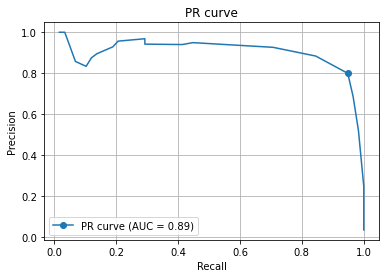

AUC：0.885038241356334
閾値：0.21052631578947367
F値：0.8673283488551733
適合率：0.7991137370753324
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=3


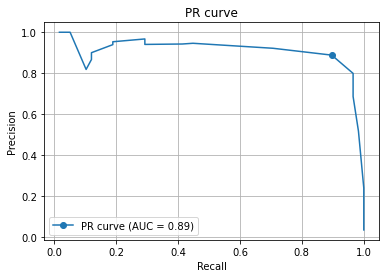

AUC：0.8931559642898915
閾値：0.2631578947368421
F値：0.8923214803489996
適合率：0.888130968622101
再現率：0.896551724137931
-----------------------------------------------------------------------
nk=4


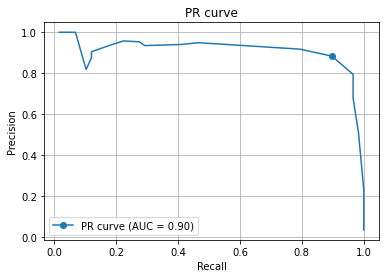

AUC：0.8951222560436933
閾値：0.2631578947368421
F値：0.8900448341631368
適合率：0.8836317135549873
再現率：0.896551724137931
-----------------------------------------------------------------------
nk=5


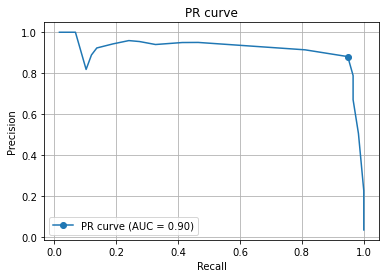

AUC：0.8994506105162664
閾値：0.2631578947368421
F値：0.9133290230373975
適合率：0.8808664259927798
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=6


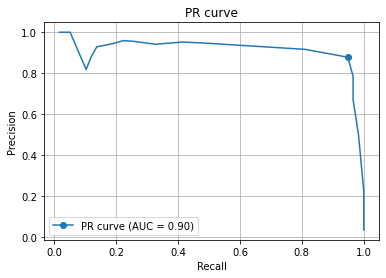

AUC：0.8982088252766505
閾値：0.2631578947368421
F値：0.9117653638783865
適合率：0.8779620853080569
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=7


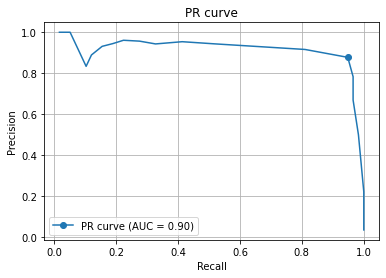

AUC：0.8985776107460968
閾値：0.2631578947368421
F値：0.9113934918863228
適合率：0.8772727272727273
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=8


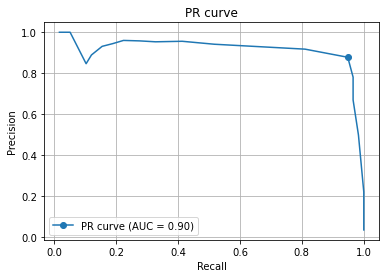

AUC：0.8998891573712995
閾値：0.2631578947368421
F値：0.9115926349953261
適合率：0.8776418242491657
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=9


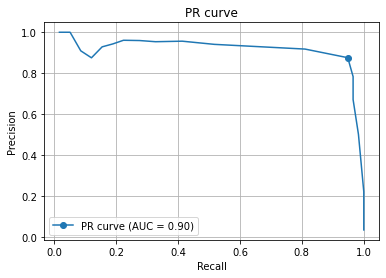

AUC：0.9005861511944079
閾値：0.2631578947368421
F値：0.9104686407087899
適合率：0.875560538116592
再現率：0.9482758620689655
-----------------------------------------------------------------------


In [47]:
test_day=[3]
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    print(f'nk={i}')
    train=df[(~df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    
    nk = i
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx
    
    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
    
    d=test_v['d'].values
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = PR_curve.fig_pr(test_v, d, thr_bins)
    print(f'AUC：{auc}')
    print(f'閾値：{thr}')
    print(f'F値：{f_score.max()}')
    print(f'適合率：{p_score[np.argmax(f_score)]}')
    print(f'再現率：{r_score[np.argmax(f_score)]}')
    print('-----------------------------------------------------------------------')

# nk 10~19

nk=10


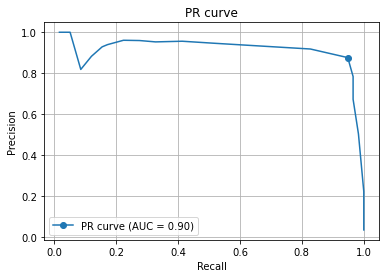

AUC：0.8996086391556708
閾値：0.2631578947368421
F値：0.9106988737466836
適合率：0.8759864712514093
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=11


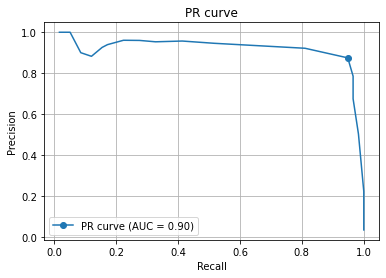

AUC：0.9025864483236976
閾値：0.2631578947368421
F値：0.9100141759939064
適合率：0.8747203579418344
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=12


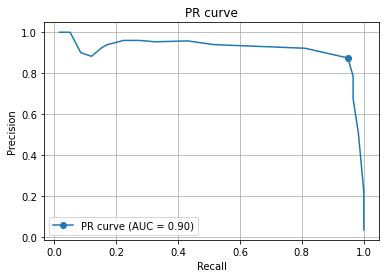

AUC：0.9014716579478488
閾値：0.2631578947368421
F値：0.9098621420996819
適合率：0.874439461883408
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=13


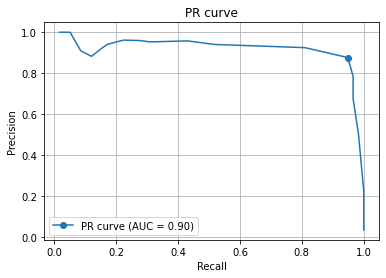

AUC：0.9026992747971682
閾値：0.2631578947368421
F値：0.9108435258051262
適合率：0.8762541806020067
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=14


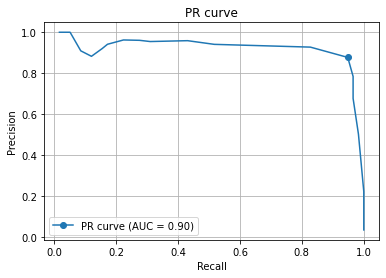

AUC：0.9041671323067936
閾値：0.2631578947368421
F値：0.9112139745308311
適合率：0.876940133037694
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=15


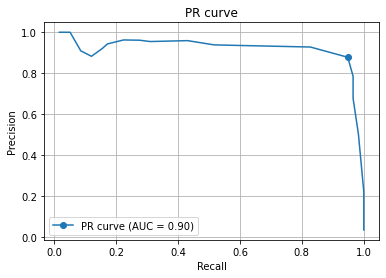

AUC：0.9038628711349804
閾値：0.2631578947368421
F値：0.9115800651723527
適合率：0.8776185226019846
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=16


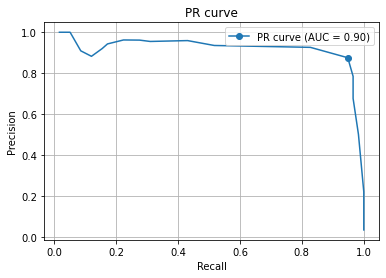

AUC：0.9028806774687936
閾値：0.2631578947368421
F値：0.9103871547689161
適合率：0.8754098360655738
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=17


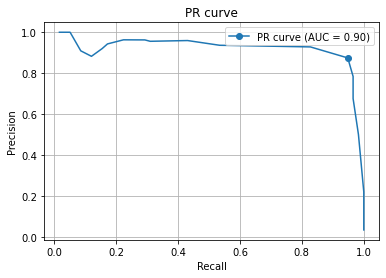

AUC：0.9039432339872132
閾値：0.2631578947368421
F値：0.9098726505876089
適合率：0.8744588744588745
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=18


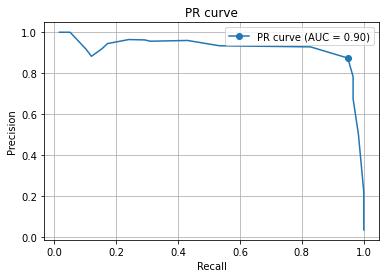

AUC：0.9047588343576017
閾値：0.2631578947368421
F値：0.9095821692938274
適合率：0.8739224137931034
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=19


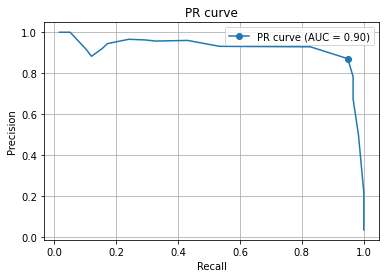

AUC：0.9042102269240295
閾値：0.2631578947368421
F値：0.9078481012658228
適合率：0.8707264957264957
再現率：0.9482758620689655
-----------------------------------------------------------------------


In [49]:
test_day=[3]
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
for i in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    print(f'nk={i}')
    train=df[(~df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    
    nk = i
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx
    
    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
    
    d=test_v['d'].values
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = PR_curve.fig_pr(test_v, d, thr_bins)
    print(f'AUC：{auc}')
    print(f'閾値：{thr}')
    print(f'F値：{f_score.max()}')
    print(f'適合率：{p_score[np.argmax(f_score)]}')
    print(f'再現率：{r_score[np.argmax(f_score)]}')
    print('-----------------------------------------------------------------------')

# nk 20~29

nk=20


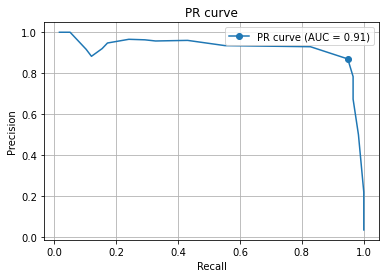

AUC：0.905366734396117
閾値：0.2631578947368421
F値：0.9072164948453608
適合率：0.8695652173913043
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=21


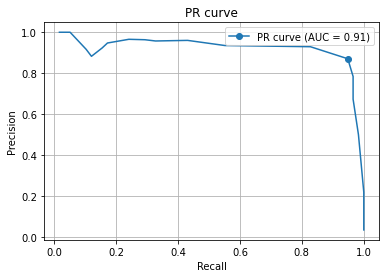

AUC：0.9056100746898714
閾値：0.2631578947368421
F値：0.9076651049419099
適合率：0.8703898840885143
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=22


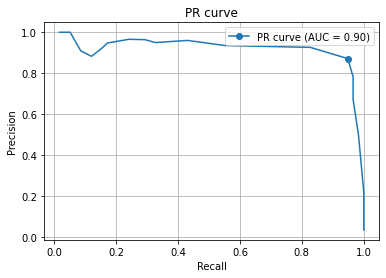

AUC：0.9031923433398948
閾値：0.2631578947368421
F値：0.908034330671117
適合率：0.8710691823899371
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=23


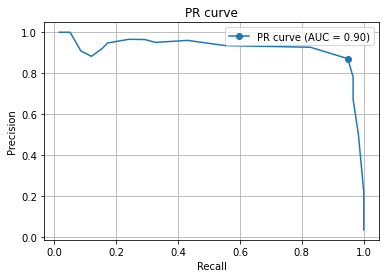

AUC：0.9032372324002352
閾値：0.2631578947368421
F値：0.9079061685490877
適合率：0.8708333333333333
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=24


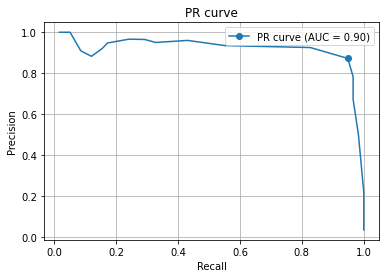

AUC：0.9030410219178303
閾値：0.2631578947368421
F値：0.9085443381070186
適合率：0.8720083246618107
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=25


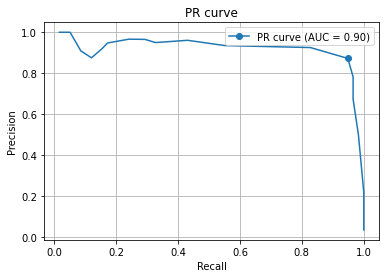

AUC：0.9028452232189732
閾値：0.2631578947368421
F値：0.9086165478675224
適合率：0.8721413721413721
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=26


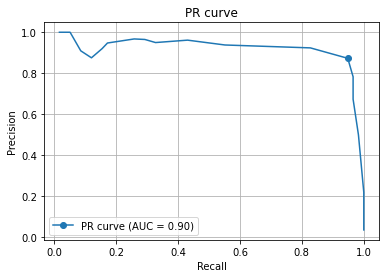

AUC：0.9031134748925465
閾値：0.2631578947368421
F値：0.9088322163456349
適合率：0.8725388601036269
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=27


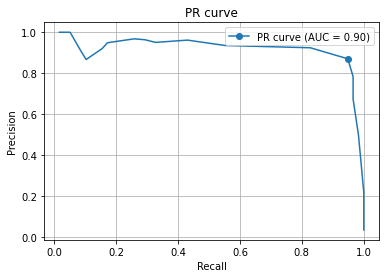

AUC：0.9025334396272353
閾値：0.2631578947368421
F値：0.9075818971830298
適合率：0.870236869207003
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=28


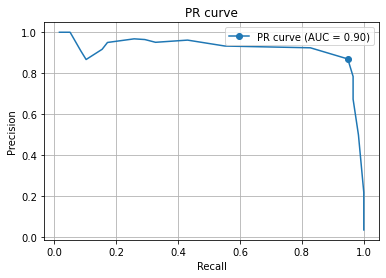

AUC：0.901921752763161
閾値：0.2631578947368421
F値：0.9071678543228409
適合率：0.869475847893114
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=29


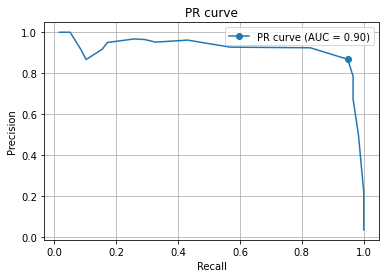

AUC：0.901284020963742
閾値：0.2631578947368421
F値：0.9061220510820822
適合率：0.8675564681724846
再現率：0.9482758620689655
-----------------------------------------------------------------------


In [50]:
test_day=[3]
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
for i in [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]:
    print(f'nk={i}')
    train=df[(~df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    
    nk = i
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx
    
    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
    
    d=test_v['d'].values
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = PR_curve.fig_pr(test_v, d, thr_bins)
    print(f'AUC：{auc}')
    print(f'閾値：{thr}')
    print(f'F値：{f_score.max()}')
    print(f'適合率：{p_score[np.argmax(f_score)]}')
    print(f'再現率：{r_score[np.argmax(f_score)]}')
    print('-----------------------------------------------------------------------')

# nk 20~90

nk=20


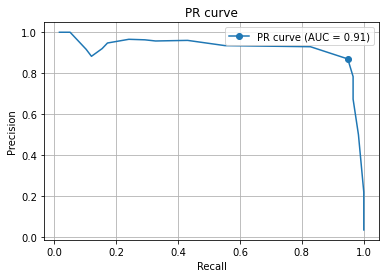

AUC：0.905366734396117
閾値：0.2631578947368421
F値：0.9072164948453608
適合率：0.8695652173913043
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=30


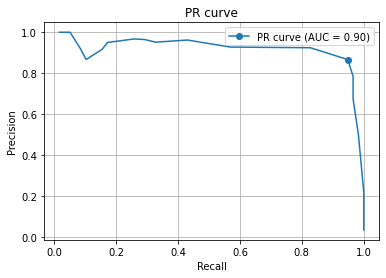

AUC：0.9013702865118985
閾値：0.2631578947368421
F値：0.9054868224472459
適合率：0.8663926002055499
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=40


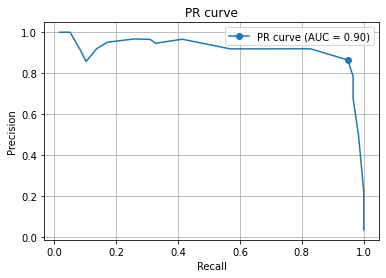

AUC：0.8990916110958217
閾値：0.2631578947368421
F値：0.9044105527492026
適合率：0.8644240570846076
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=50


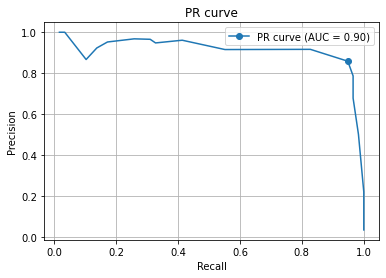

AUC：0.8960528644607452
閾値：0.2631578947368421
F値：0.9011260457172632
適合率：0.8584428715874621
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=60


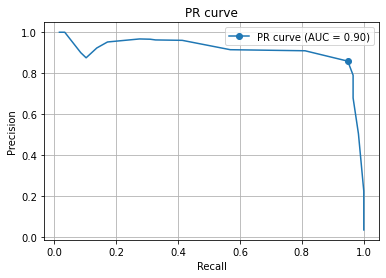

AUC：0.8953739624161455
閾値：0.2634619645912421
F値：0.9012834214301532
適合率：0.858728557013118
再現率：0.9482758620689655
-----------------------------------------------------------------------
nk=70


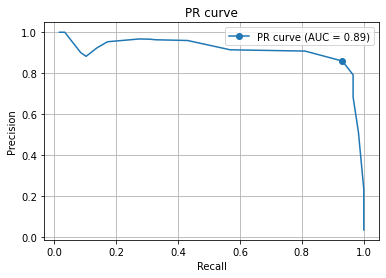

AUC：0.8949054416638903
閾値：0.2646753185089283
F値：0.8936672038995243
適合率：0.8591836734693877
再現率：0.9310344827586207
-----------------------------------------------------------------------
nk=80


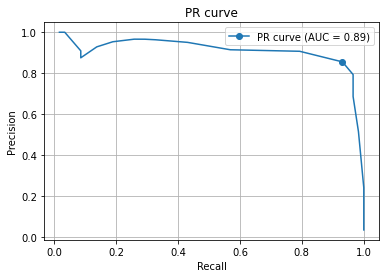

AUC：0.8931825754502924
閾値：0.26552906742974014
F値：0.8914462588543424
適合率：0.8550873586844809
再現率：0.9310344827586207
-----------------------------------------------------------------------
nk=90


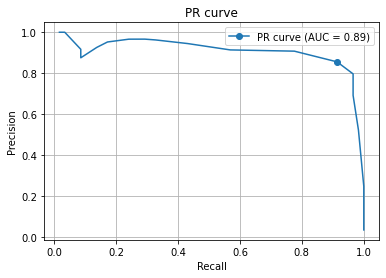

AUC：0.8917074112848482
閾値：0.2661371475367267
F値：0.883523046871005
適合率：0.8551941238195173
再現率：0.9137931034482759
-----------------------------------------------------------------------


In [48]:
test_day=[3]
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
for i in [20, 30, 40, 50, 60, 70, 80, 90]:
    print(f'nk={i}')
    train=df[(~df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    test=df[(df['day'].isin(test_day))][df.columns[:-2]].reset_index(drop=True)
    
    nk = i
    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]
    d = np.mean(d, axis=1)
    mx = np.max(d)
    d = d / mx
    
    test_v=original[original['day'].isin(test_day)][['original', 'label']].reset_index(drop=True)
    test_v['d']=d[0]
    test_v.loc[window-1:, 'd']=d
    
    d=test_v['d'].values
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = PR_curve.fig_pr(test_v, d, thr_bins)
    print(f'AUC：{auc}')
    print(f'閾値：{thr}')
    print(f'F値：{f_score.max()}')
    print(f'適合率：{p_score[np.argmax(f_score)]}')
    print(f'再現率：{r_score[np.argmax(f_score)]}')
    print('-----------------------------------------------------------------------')